# 3 Qubit GHZ Generation
This demo shows how Lightworks can be utilized for the qubit based paradigm of quantum computing.

In [1]:
import lightworks as lw
from lightworks import State, emulator

## Theory

In the following we show a demonstration of the implementation of two successive CNOTs across 3 qubits to generate the 3 photon entangled GHZ state $\frac{1}{\sqrt{2}}(\ket{000} + \ket{111})$.

In qubit language we start with the state $\ket{000}$, a hadamard is then applied to the first qubit, this gives: 

\begin{equation} H_1\ket{000} = \frac{1}{\sqrt{2}}(\ket{000} + \ket{100}) \tag{1} \end{equation}

On application of the first CNOT between qubits 1 and 2, the state is then transformed into:

\begin{equation} CNOT_{1,2}\;\frac{1}{\sqrt{2}}(\ket{000} + \ket{100}) = \frac{1}{\sqrt{2}}(\ket{000} + \ket{110}) \tag{2} \end{equation}

Then, on application of the second CNOT between qubits 2 and 3, we get the GHZ state:

\begin{equation} CNOT_{2,3}\;\frac{1}{\sqrt{2}}(\ket{000} + \ket{110}) = \frac{1}{\sqrt{2}}(\ket{000} + \ket{111}) \tag{3} \end{equation}

## Circuit
We can create the circuit described with the code in the cell below. The included lightworks qubit components are used to simplify the construction, abstracting the required heralds of the circuit.

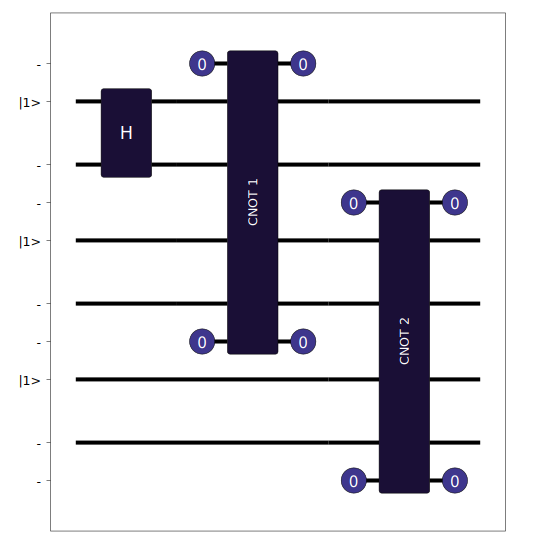

In [2]:
# Define cnot and H components
cnot_circuit = lw.qubit.CNOT()
h_circuit = lw.qubit.H()

# We will then define the larger overall circuit - 3 qubits so 6 modes
circuit = lw.PhotonicCircuit(6)

# First add the initial Hadamard (H) gate which acts on qubit 1.
circuit.add(h_circuit)
# Then include the first CNOT, grouping all components
circuit.add(cnot_circuit, 0, group=True, name="CNOT 1")
# Then add second CNOT
circuit.add(cnot_circuit, 2, group=True, name="CNOT 2")

# Use display method, we will assign mode labels which allow us to mark which
# mode the photons should be input on
circuit.display(
    display_type="svg", mode_labels=["|1>", "-", "|1>", "-", "|1>", "-"]
)

## Simulation with perfect system
The system is then simulated to check the expected output.

As part of the simulation, we will define what is known as a post-selection function, meaning that we will only accept outputs for which a particular rule is true. We then use the Sampler again to find the outputs from the system. As heralds were included in the original circuit we do not need to specify these modes.

In [4]:
# Define post-selection
post_select = (
    lambda s: sum(s[0:2]) == 1 and sum(s[2:4]) == 1 and sum(s[4:6]) == 1
)
sampler = lw.Sampler(
    circuit,
    State([1, 0, 1, 0, 1, 0]),
    100000,
    post_selection=post_select,
    random_seed=1,
)

backend = emulator.Backend("slos")
results = backend.run(sampler)

# Process with function
converted_results = results.map(lw.convert.dual_rail_to_qubit)

These results can then be plotted, and the two expected measurement outcomes, the state $\frac{1}{\sqrt{2}}(\ket{000} + \ket{111})$, are seen.

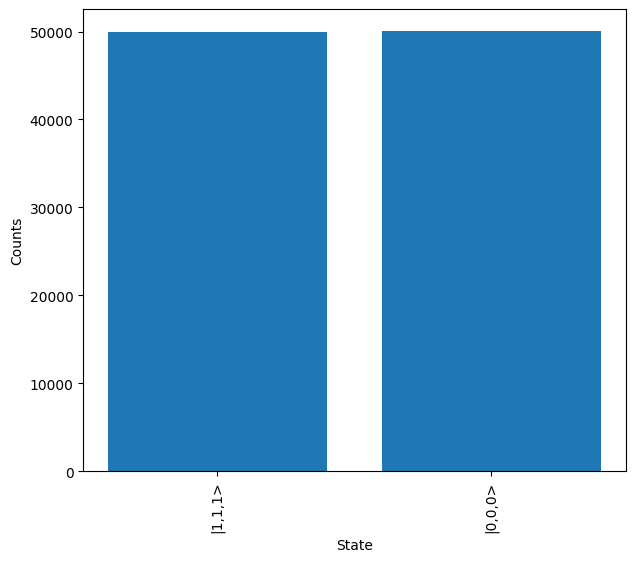

In [5]:
converted_results.plot()

## Simulation with imperfect source and detectors
Unfortunately, the components of our system are not perfect, and these imperfections will alter the results we see. It is possible to simulate these imperfections in the emulator to better understand the affect they have. To do this we will modify some of the attributes of the Sampler object to account for imperfections in the single photon source and detector modules of the system.

.. note:: The sampling mode needs to be changed to input to include imperfections in the detection system.

In [6]:
sampler.source = emulator.Source(indistinguishability=0.98, purity=0.98)
sampler.detector = emulator.Detector(efficiency=0.8, p_dark=1e-6)
sampler.sampling_mode = "input"

The results can then be recalculated and then plotted again.

Here we see some states other than the 000 and 111 outputs we expected, demonstrating the potential effect of errors within the system.

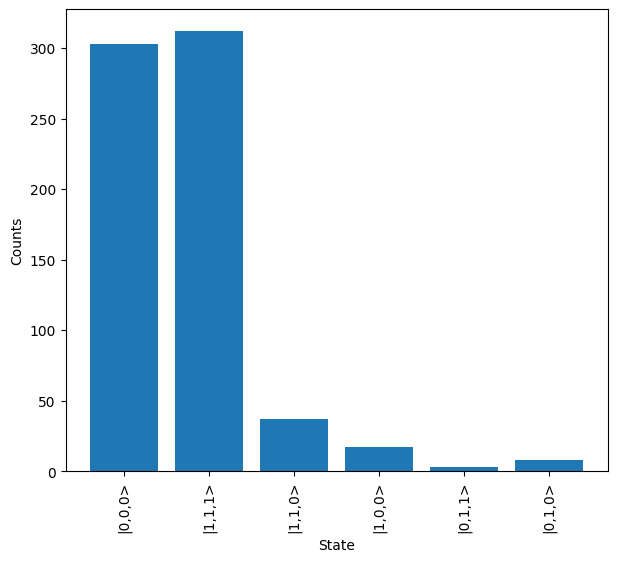

In [8]:
results = backend.run(sampler)

# Process with function
converted_results = results.map(lw.convert.dual_rail_to_qubit)

converted_results.plot()